<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill">
    <h1 style="text-align: center;padding: 12px 0px 12px 0px;">🚢 Titanic: XGBoost + Optuna</h1>
</div>
<img src="https://www.seekpng.com/png/full/200-2002376_predicting-titanic-survivors-old-photos-of-the-titanic.png" alt="Titanic" width="300"/>



# Understanding the Titanic Data

## Target - What we want to predict

For the Titantic dataset the target is:`Survived`

## Features

- `Pclass` - Ticket class (1st,2nd,3rd)
- `Name` - Full name
- `Sex` - Gender
- `Age` - Passenger's age
- `SibSp` - # of siblings / spouses aboard the Titanic
- `Parch` - # of parents / children aboard the Titanic
- `Ticket` - Ticket number
- `Fare` - What the passenger paid for a ticket
- `Cabin` - Cabin number
- `Embarked` - C = Cherbourg, Q = Queenstown, S = Southampton

## Evaluation Metric

$Acurracy = \frac{True Positives (TP) + True Negatives (TN)}{True Positives (TP) + True Negatives (TN) + False Positives(FP) + False Negatives(FN)}$

- https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification

Percentage of passengers you correctly predict.  In other words, accurately predict who survived and who did not.

- https://developers.google.com/machine-learning/crash-course/classification/accuracy



In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [2]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold

# from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

from itertools import cycle

plt.style.use("ggplot")  # ggplot, fivethirtyeight
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [3]:
class Config:
    path = "../input/titanic"
    gpu = False
    debug = False
    optimize = False
    model_type = "tf"  # (xgb, cat, lgbm, keras)
    model_name = "tf1"
    competition = "titanic"
    calc_probability = True
    seed = 42
    N_ESTIMATORS = 100  # 100, 300, 2000, 5000 GBDT

    batch_size = 64
    epochs = 25
    N_FOLDS = 5  # 5,10,15
    SEED_LENGTH = 1  # 5,10

### The target/dependent variable in the dataset

In [4]:
# Did the passenger survive?
# 0 = No, 1 = Yes
TARGET = "Survived"

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that we will reuse in each project.

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "gender_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def create_submission(model_name, target, preds):
    sample_submission[target] = preds

    if len(model_name) > 0:
        fname = "submission_{model_name}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission

In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)


def show_scores(gt, yhat):
    accuracy = accuracy_score(gt, yhat)
    precision = precision_score(gt, yhat)
    recall = recall_score(gt, yhat)
    f1 = f1_score(gt, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"f1: {f1:.4f}")

In [8]:
from sklearn.preprocessing import LabelEncoder


def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [9]:
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = OneHotEncoder().fit_transform(train[col])
        test[col] = OneHotEncoder().fit_transform(test[col])
    return train, test

In [10]:
def show_missing_features(df):
    missing_vals = df.isna().sum()
    print(missing_vals[missing_vals > 0])

In [11]:
def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

In [12]:
def show_fold_scores(scores):
    cv_score = np.mean(scores)  # Used in filename
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )

In [13]:
# Save OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the `Suvived` target variable
 - gender_submission.csv - A file in the proper format to submit test predictions

In [14]:
train, test, sample_submission = read_data(Config.path)

train data: Rows=891, Columns=12
test data : Rows=418, Columns=11


In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
train = train.drop(columns=["Name", "Ticket", "Cabin"], axis=1).copy()
# test = test.drop(columns=["PassengerId"], axis=1).copy()

## Categorical/Numerical Variables

In [18]:
## Separate Categorical and Numerical Features
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)
num_features.remove("PassengerId")

FEATURES = cat_features + num_features
FEATURES

['Sex', 'Embarked', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [19]:
from sklearn.impute import SimpleImputer

# Categorical
imputer = SimpleImputer(strategy="most_frequent")

train[cat_features] = imputer.fit_transform(train[cat_features])
test[cat_features] = imputer.transform(test[cat_features])

# Numerical

# imputer = SimpleImputer(strategy="mean")
imputer = SimpleImputer(strategy="median")  # median is more robust to outliers

train[num_features] = imputer.fit_transform(train[num_features])
test[num_features] = imputer.transform(test[num_features])

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

- [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial)
- [Titanic Survival Predictions (Beginner)](https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner)
- [Exploring Survival on the Titanic](https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic)

In [20]:
# FEATURES = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked"]

In [21]:
train[FEATURES].head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,S,3.0,22.0,1.0,0.0,7.2500
1,female,C,1.0,38.0,1.0,0.0,71.2833
2,female,S,3.0,26.0,0.0,0.0,7.9250
3,female,S,1.0,35.0,1.0,0.0,53.1000
4,male,S,3.0,35.0,0.0,0.0,8.0500


# Extract Target and Drop Unused Columns

In [22]:
# y = train[TARGET]

# X = train_df.drop(columns=["PassengerId", "Survived"], axis=1).copy()
# X = train[FEATURES].copy()

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Missing Values</h1>
</div>

We have 891 rows of training data. Age is the only feature, that we are using, with missing data.

Note, handling missing data is an entire subject that should be studied in detail.  Kaggle offers a [course](https://www.kaggle.com/learn/data-cleaning)

- [sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/impute.html)
- https://scikit-learn.org/stable/modules/impute.html

- [A Guide to Handling Missing values in Python](https://www.kaggle.com/parulpandey/a-guide-to-handling-missing-values-in-python)

In [23]:
show_missing_features(train)

Series([], dtype: int64)


In [24]:
n = train["Age"].isna().sum()
print(f"Number missing: {n}")

Number missing: 0


### Manual Imputation of Age

In [25]:
# train_df["Age"].fillna(train_df["Age"].mean(), inplace = True)
m = train["Age"].mean()
print(f"Mean age of person on the Titanic: {m:0.2f}")

Mean age of person on the Titanic: 29.36


In [26]:
train["Age"].fillna(train["Age"].median(skipna=True), inplace=True)
train["Embarked"].fillna(train["Embarked"].value_counts().idxmax(), inplace=True)

### Use SimpleImputer Function for Age

Leaving the SimpleImputer code uncommented.  It should do nothing since we filled in the values above.

In [27]:
impute_mean = SimpleImputer(missing_values=np.nan, strategy="mean", verbose=1)
m = impute_mean.fit_transform(train[["Age"]])
# mt = impute_mean.transform(test[["Age"]])

train["Age"] = impute_mean.fit_transform(train[["Age"]])
test["Age"] = impute_mean.transform(test[["Age"]])

### At this point we no longer have missing values

In [28]:
show_missing_features(train)

Series([], dtype: int64)


# Encoding Categorical Features

Need to convert categorical features into numerical features.

Several ways:
- One-hot Encode
- Label Encode

### Encode `Embarked`

First compare what the **drop_first=True** option does.  Some machine learning models require this option while others do not.  Logitistic regression requires us to drop the value.

In [29]:
train, test = label_encoder(train, test, ["Embarked", "Sex"])
# X_test = pd.get_dummies(test[FEATURES], drop_first=True)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3.0,1,22.0,1.0,0.0,7.2500,2
1,2,1,1.0,0,38.0,1.0,0.0,71.2833,0
2,3,1,3.0,0,26.0,0.0,0.0,7.9250,2
3,4,1,1.0,0,35.0,1.0,0.0,53.1000,2
4,5,0,3.0,1,35.0,0.0,0.0,8.0500,2


- [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [30]:
# y = train[TARGET]
# X = train[FEATURES].copy()

# X_test = test[FEATURES].copy()

In [31]:
train = create_folds(train, TARGET, Config.N_FOLDS)

TARGET=Survived, n_folds=5, seed=42


In [32]:
submission_df = test[["PassengerId"]].copy()
oof = train[["PassengerId", TARGET, "fold"]].reset_index(drop=True).copy()
oof.head()

,PassengerId,Survived,fold
0,1,0,1
1,2,1,4
2,3,1,3
3,4,1,3
4,5,0,0


## Train Model

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Model with Cross Validation</h1>
</div>

Four out five folds will be used for training. The fifth will be used for validation

Each fold will have a turn at being the validation fold

After each time through the loop


In [33]:
def train_xgb_model(
    df,
    test,
    get_model_fn,
    FEATURES,
    TARGET,
    calc_probability,
    rowid,
    params,
    n_folds=5,
    seed=42,
):

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    # oof_preds = np.zeros((df.shape[0],)) # Zero array
    # print(f"oof_preds size={df.shape[0]}")
    #     print(
    #         f"\n===== XGBoost Estimators: {params['n_estimators']}, Random State: {seed} ====="
    #     )

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = (
            xvalid.PassengerId.values.tolist()
        )  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]
        xtrain.head()

        model = get_model_fn()

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #              eval_metric = "auc",
            verbose=False,
            early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        # Mean of the predictions
        #         preds_valid = model.predict(xvalid)
        #         test_preds = model.predict(xtest)
        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        #         fold_score = accuracy_score(yvalid, preds_valid)  # Validation Set Score
        fold_score = roc_auc_score(yvalid, preds_valid)  # Validation Set Score

        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, AUC: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )

In [34]:
xgb_params = {
    "enable_categorical": True,
    "n_estimators": 1000,
    "learning_rate": 0.021138659045230178,
    "subsample": 0.4,
    "colsample_bytree": 0.91,
    "max_depth": 17,
    "gamma": 0.6000000000000001,
    "booster": "gbtree",
    "tree_method": "hist",
    "reg_lambda": 0.005882742898970815,
    "reg_alpha": 0.0014501578157205654,
    "random_state": 42,
    "n_jobs": 4,
    "min_child_weight": 5.567082153821453,
}

In [35]:
def get_xgb_clf_model():
    #     model = xgb.XGBClassifier(n_estimators=1000)
    model = xgb.XGBClassifier(**xgb_params)
    return model

In [36]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html

lgbm_params = {
    "n_estimators": Config.N_ESTIMATORS,
    #     "device_type": "gpu",
    #     "objective": "multiclass",
    #     "metric": "multi_logloss",
    "objective": "binary",
    "metric": "auc",
    "lambda_l1": 0.009130931198077825,
    "lambda_l2": 3.530680683338868e-05,
    #     "reg_alpha": 0.009130931198077825,
    #     "reg_lambda": 3.530680683338868e-05,
    "num_leaves": 430,
    "importance_type": "split",
    #     "learning_rate": 0.029330486500731102,
    "learning_rate": 0.1,
    "feature_fraction": 0.8757445736567416,
    "bagging_fraction": 0.9989307214277753,
    "bagging_freq": 10,
    "min_child_samples": 20,
    "random_state": 42,
    "n_jobs": -1,
}
if Config.gpu:
    lgbm_params["device_type"] = "gpu"

In [37]:
def get_lgbm_clf_model():
    model = lgb.LGBMClassifier(**lgbm_params)
    return model

In [38]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train,
    test,
    get_xgb_clf_model,
    FEATURES,
    TARGET,
    Config.calc_probability,
    "PassengerId",
    xgb_params,
    Config.N_FOLDS,
    Config.seed,
)

========== Fold 1/5 ==========


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


fold: 1, AUC: 0.918642951251647, Run Time: 3.98
========== Fold 2/5 ==========


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


fold: 2, AUC: 0.8922459893048129, Run Time: 4.01
========== Fold 3/5 ==========


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


fold: 3, AUC: 0.8428475935828879, Run Time: 3.81
========== Fold 4/5 ==========


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


fold: 4, AUC: 0.8683823529411765, Run Time: 3.85
========== Fold 5/5 ==========


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


fold: 5, AUC: 0.8798032176572264, Run Time: 4.84


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Scores</h1>
</div>

CV, or Cross Validation, Score.

We average the means and the standard deviations.

The Adjusted Score is the average of the means minus the average of standard deviation. Do this to attempt to get one number to evaluate the score when comparing different models.

In [39]:
show_fold_scores(fold_scores)

Scores -> Adjusted: 0.85525351 , mean: 0.88038442, std: 0.02513091


In [40]:
final_valid_predictions_df = pd.DataFrame.from_dict(
    final_valid_predictions, orient="index"
).reset_index()
final_valid_predictions_df.columns = ["id", "pred_xgb1"]
final_valid_predictions_df.to_csv("train_pred_xgb1.csv", index=False)

In [41]:
oof["pred_xgb1"] = final_valid_predictions_df["pred_xgb1"]
oof.head()

,PassengerId,Survived,fold,pred_xgb1
0,1,0,1,0.163485
1,2,1,4,0.235179
2,3,1,3,0.074338
3,4,1,3,0.703031
4,5,0,0,0.386051


In [42]:
from scipy.stats import mode

if Config.calc_probability:
    print("Mean")
    result = np.mean(np.column_stack(final_test_predictions), axis=1)
#     result = np.rint(m).astype(int)
#     display(result)
else:
    print("Mode")
    mode_result = mode(np.column_stack(final_test_predictions), axis=1)
    result = mode_result[0].ravel()

result[:20]

Mean


array([0.12707493, 0.24531329, 0.0601217 , 0.15703344, 0.36903167,
       0.2520413 , 0.6464669 , 0.14999278, 0.7070511 , 0.03526946,
       0.05098905, 0.17711352, 0.91629744, 0.07315017, 0.9425286 ,
       0.87489337, 0.2211051 , 0.15072212, 0.6656117 , 0.44384485],
      dtype=float32)

In [43]:
# submission_df["target_xgb1"] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission_df["target_xgb1"] = result
submission_df.head(10)

,PassengerId,target_xgb1
0,892,0.127075
1,893,0.245313
2,894,0.060122
3,895,0.157033
4,896,0.369032
5,897,0.252041
6,898,0.646467
7,899,0.149993
8,900,0.707051
9,901,0.035269


## LGBM Model

In [44]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train,
    test,
    get_lgbm_clf_model,
    FEATURES,
    TARGET,
    Config.calc_probability,
    "PassengerId",
    lgbm_params,
    Config.N_FOLDS,
    Config.seed,
)

========== Fold 1/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05
fold: 1, AUC: 0.9148221343873518, Run Time: 0.16
========== Fold 2/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753,

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecat

fold: 2, AUC: 0.902139037433155, Run Time: 0.10
========== Fold 3/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05
fold: 3, AUC: 0.8584893048128343, Run Time: 0.10
========== Fold 4/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warn

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecat

fold: 5, AUC: 0.8966892700438771, Run Time: 0.10


In [45]:
show_fold_scores(fold_scores)

Scores -> Adjusted: 0.86673350 , mean: 0.88802421, std: 0.02129070


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Save OOF Predictions</h1>
</div>

This is unused for this example but needed later for [Blending](https://towardsdatascience.com/ensemble-learning-stacking-blending-voting-b37737c4f483).

**General idea**: The values will be use to create new features in a blended model.

- [Stacking and Blending — An Intuitive ExplanationStacking and Blending — An Intuitive Explanation](https://medium.com/@stevenyu530_73989/stacking-and-blending-intuitive-explanation-of-advanced-ensemble-methods-46b295da413chttps://medium.com/@stevenyu530_73989/stacking-and-blending-intuitive-explanation-of-advanced-ensemble-methods-46b295da413c)

In [46]:
final_valid_predictions_df = pd.DataFrame.from_dict(
    final_valid_predictions, orient="index"
).reset_index()
final_valid_predictions_df.columns = ["id", "pred_lgbm1"]
final_valid_predictions_df.to_csv("train_pred_lgbm1.csv", index=False)

In [47]:
oof["pred_lgbm1"] = final_valid_predictions_df["pred_lgbm1"]
oof.head()

,PassengerId,Survived,fold,pred_xgb1,pred_lgbm1
0,1,0,1,0.163485,0.077964
1,2,1,4,0.235179,0.049935
2,3,1,3,0.074338,0.128361
3,4,1,3,0.703031,0.673995
4,5,0,0,0.386051,0.271104


In [48]:
from scipy.stats import mode

if Config.calc_probability:
    print("Mean")
    result = np.mean(np.column_stack(final_test_predictions), axis=1)
#     result = np.rint(m).astype(int)
#     display(result)
else:
    print("Mode")
    mode_result = mode(np.column_stack(final_test_predictions), axis=1)
    result = mode_result[0].ravel()

result[:20]

Mean


array([0.07866885, 0.26068843, 0.08841815, 0.28875258, 0.29955905,
       0.37177733, 0.50750124, 0.18450079, 0.73589166, 0.04400028,
       0.0334911 , 0.12490202, 0.94775474, 0.04540242, 0.9431925 ,
       0.88002872, 0.11788597, 0.30616484, 0.51443279, 0.50999095])

In [49]:
submission_df["target_lgbm1"] = result
submission_df.head(10)

,PassengerId,target_xgb1,target_lgbm1
0,892,0.127075,0.078669
1,893,0.245313,0.260688
2,894,0.060122,0.088418
3,895,0.157033,0.288753
4,896,0.369032,0.299559
5,897,0.252041,0.371777
6,898,0.646467,0.507501
7,899,0.149993,0.184501
8,900,0.707051,0.735892
9,901,0.035269,0.044000


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Weighted Blend Based on OOF</h1>
</div>

In [50]:
oof.head()

,PassengerId,Survived,fold,pred_xgb1,pred_lgbm1
0,1,0,1,0.163485,0.077964
1,2,1,4,0.235179,0.049935
2,3,1,3,0.074338,0.128361
3,4,1,3,0.703031,0.673995
4,5,0,0,0.386051,0.271104


In [51]:
pred_cols = [c for c in submission_df.columns if c.startswith("pred_")]
pred_cols

[]

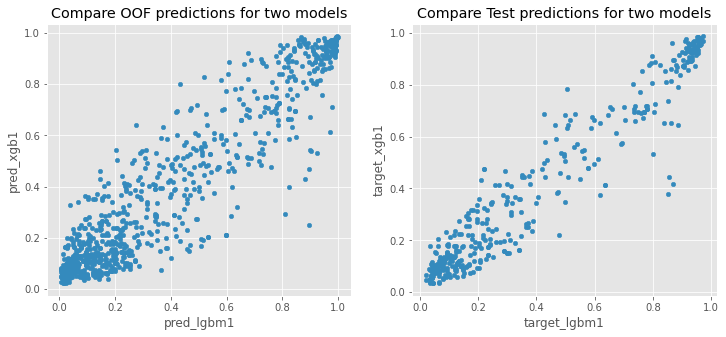

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
oof.plot(
    x="pred_lgbm1",
    y="pred_xgb1",
    kind="scatter",
    title="Compare OOF predictions for two models",
    ax=axs[0],
)

submission_df.plot(
    x="target_lgbm1",
    y="target_xgb1",
    kind="scatter",
    title="Compare Test predictions for two models",
    ax=axs[1],
)
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_error


def get_oof_score(weight, oof, pred_model1, pred_model2):
    blend_pred = (oof[pred_model1] * weight) + (oof[pred_model2] * (1 - weight))
    return mean_absolute_error(oof[TARGET], blend_pred)

In [54]:
myscores = {}
for weight in range(100):
    weight /= 100
    score = get_oof_score(weight, oof, "pred_lgbm1", "pred_xgb1")
    myscores[weight] = score

In [55]:
blend_results = pd.DataFrame(myscores, index=["score"]).T

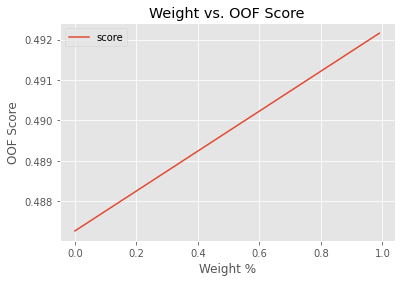

In [56]:
ax = blend_results.plot(title="Weight vs. OOF Score")
ax.set_xlabel("Weight %")
ax.set_ylabel("OOF Score")
plt.show()

### The Blended Weight is ...

In [57]:
blend_results.loc[blend_results["score"] == blend_results["score"].min()]

,score
0.0,0.48726


In [58]:
blend_score = blend_results["score"].min()
best_cv_score = 0.004722
print(f"Blended Score: {blend_score:.8f}")

Blended Score: 0.48726010


In [59]:
w = blend_results.loc[blend_results["score"] == blend_results["score"].min()]
w

,score
0.0,0.48726


In [60]:
wt = w.first_valid_index()
wt

0.0

In [61]:
blend_results["score"]

0.00    0.487260
0.01    0.487310
0.02    0.487359
0.03    0.487408
0.04    0.487458
          ...   
0.95    0.491959
0.96    0.492008
0.97    0.492058
0.98    0.492107
0.99    0.492157
Name: score, Length: 100, dtype: float64

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Submission File</h1>
</div>

The sample file and our data is in the same row order.  This allows us to simply assign our prediction to the target column (`Survived`) in the sample submission.

In [62]:
# pred_cols = [c for c in submission_df.columns if c.startswith("pred_")]
# pred_cols

In [63]:
submission_df.head()

,PassengerId,target_xgb1,target_lgbm1
0,892,0.127075,0.078669
1,893,0.245313,0.260688
2,894,0.060122,0.088418
3,895,0.157033,0.288753
4,896,0.369032,0.299559


In [64]:
# submission_df["target"] = (submission_df["target_lgbm1"] * wt) + (
#     submission_df["target_lgbm2"] * (1 - wt)
# )

In [65]:
print(f"Weights=({wt}, {1-wt})")

sample_submission[TARGET] = (submission_df["target_xgb1"] * wt) + (
    submission_df["target_lgbm1"] * (1 - wt)
)
sample_submission.head(8)

Weights=(0.0, 1.0)


,PassengerId,Survived
0,892,0.078669
1,893,0.260688
2,894,0.088418
3,895,0.288753
4,896,0.299559
5,897,0.371777
6,898,0.507501
7,899,0.184501


In [66]:
sample_submission["Survived"] = np.rint(sample_submission["Survived"]).astype(int)
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head(8)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
